In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

Основные способы отследить переобучение:

hold-out-разбиение,
k-fold-валидация и leave-one-out-валидация,
кривые обучения (learning curves).
Если качество на валидационной выборке стабильно хуже качества на тренировочной, то это явный признак переобучения.

Рассмотрим пример. Будем использовать тот же набор данных об образцах воды.

Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику -score:

In [2]:
water_data = pd.read_csv('data/water_potability.csv')

In [3]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [4]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [5]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


Значение -score на тренировочной выборке показывает, что задача классификации образцов воды на пригодные и непригодные для питья решена идеально. Метрика равна максимуму — 1, а значит, и precision и recall для каждого из классов равны 1 (значит, и значения всех остальных метрик тоже максимальны). То есть модель правильно определила класс для всех образцов воды из набора данных.
Однако значение -score, полученное на валидационной выборке, менее оптимистично. Значение метрики на контроле значительно ниже, чем при обучении.
Это типичная картина переобучения: модель дерева решений полностью адаптировалась под обучающий набор данных, но не нашла общих закономерностей, поэтому результаты на контроле оставляют желать лучшего.

Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику  на тренировочных и валидационных фолдах.

In [6]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.10937834, 0.08008051, 0.08711147, 0.08022523, 0.09172678]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

В полученном словаре невооруженным глазом видно, что на тренировочных фолдах значения метрик равны 1, а вот на валидационных метриках ни разу не превысила значения 0.7.

Подсчитаем среднее значение -score на выборках:

In [7]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


Задание 4.3 4.4

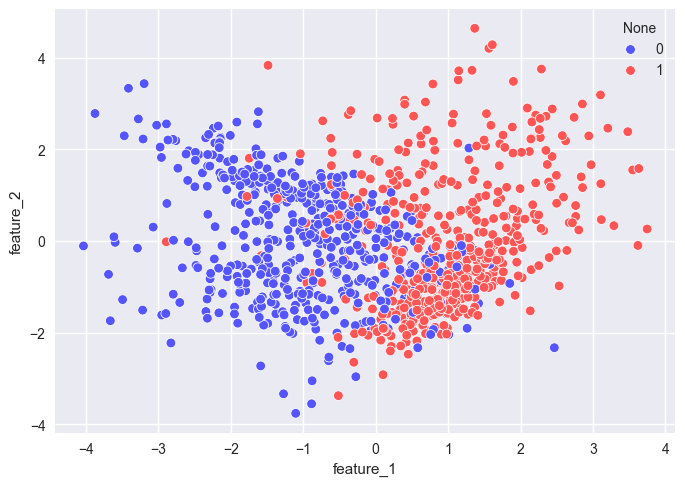

In [8]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [9]:
X_train_new, X_valid_new, y_train_new, y_valid_new = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model_new = tree.DecisionTreeClassifier(
    max_depth=10,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_new.fit(X_train_new, y_train_new)
#Делаем предсказание для каждой из выборок
y_train_pred_new = model_new.predict(X_train_new)
y_valid_pred_new = model_new.predict(X_valid_new)
#Выводим значения метрик для тренировочной выборки
print('Train accurary score: {:.2f}'.format(metrics.accuracy_score(y_train_new, y_train_pred_new)))
#Выводим значения метрик для валидационной выборки
print('Valid accurary score: {:.3f}'.format(metrics.accuracy_score(y_valid_new, y_valid_pred_new)))

Train accurary score: 0.98
Valid accurary score: 0.807


In [10]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


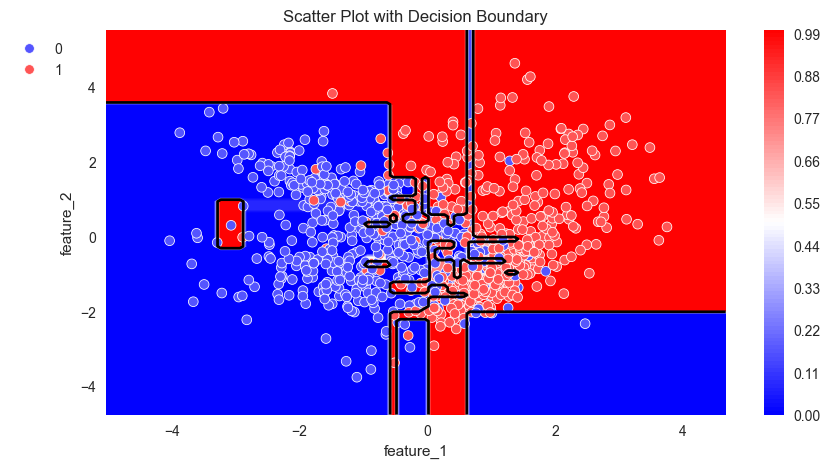

In [11]:
plot_probabilities_2d(X, y, model_new)

Сначала необходимо разобраться в причине переобучения модели. Для дерева решений установленный по умолчанию параметр max_depth будет означать, что дерево будет делиться до тех пор, пока не определит правильный класс для каждого объекта из обучающего набора данных.

На реальных данных, подверженных зашумлённости, такой подход в большинстве случаев приводит к переобучению дерева: глубина становится очень большой, и дерево не отражает общих зависимостей в данных.

В таком случае в первую очередь прибегают к «обрезке» деревьев путём ограничения максимальной глубины и/или увеличения количества объектов, при которых вершина дерева превращается в лист и деление прекращается.

Для начала посмотрим на текущую глубину дерева:

In [12]:
print('Current depth:', model_bad.get_depth())

Current depth: 27


Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [13]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.92
Valid k-fold mean f1: 0.84


После ограничения максимальной глубины удалось уменьшить разницу между метриками на тренировочных и валидационных фолдах кросс-валидации.

Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.91
Valid k-fold mean f1: 0.85


Нам удалось ещё немного сократить разницу между метриками на тренировочных и валидационных фолдах и уменьшить переобучение.

Примечание. В приведённом выше примере мы выбирали параметры исключительно по принципу «холодно-горячо». Конечно же, в реальности никто так не делает — существуют специальные механизмы перебора комбинаций внешних параметров модели, и мы познакомимся с ними в отдельном модуле.

Задание 4.5

In [15]:
X_train_new, X_valid_new, y_train_new, y_valid_new = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model_new = tree.DecisionTreeClassifier(
    max_depth=3,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_new.fit(X_train_new, y_train_new)
#Делаем предсказание для каждой из выборок
y_train_pred_new = model_new.predict(X_train_new)
y_valid_pred_new = model_new.predict(X_valid_new)
#Выводим значения метрик для тренировочной выборки
print('Train accurary score: {:.2f}'.format(metrics.accuracy_score(y_train_new, y_train_pred_new)))
#Выводим значения метрик для валидационной выборки
print('Valid accurary score: {:.2f}'.format(metrics.accuracy_score(y_valid_new, y_valid_pred_new)))

Train accurary score: 0.88
Valid accurary score: 0.85


c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


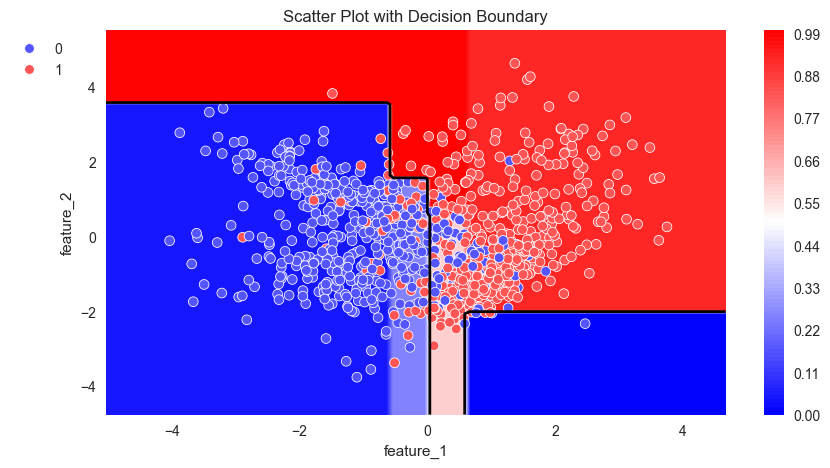

In [16]:
plot_probabilities_2d(X, y, model_new)

## Кривая обучения

In [17]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 80 260 440 620 800]
Train scores: 
 [[0.91489362 0.89473684 0.89473684 0.89473684 0.89473684]
 [0.89962825 0.91385768 0.91512915 0.91512915 0.91512915]
 [0.90153173 0.89519651 0.91938998 0.91416309 0.91416309]
 [0.90542636 0.90734824 0.92209857 0.90909091 0.9057187 ]
 [0.90794451 0.90012642 0.90813648 0.9041769  0.9081761 ]]
Valid scores: 
 [[0.78448276 0.77714286 0.75268817 0.8342246  0.83597884]
 [0.79069767 0.8172043  0.82352941 0.85436893 0.83902439]
 [0.87254902 0.82291667 0.81730769 0.85436893 0.85294118]
 [0.84210526 0.82795699 0.83168317 0.8195122  0.86138614]
 [0.86567164 0.87046632 0.82051282 0.83       0.86294416]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.8987682  0.91177468 0.90888888 0.90993656 0.90571208]
Valid k-fold f1 scores [0.79690344 0.82496494 0.8440167  0.83652875 0.84991899]


Теперь можно построить графики кривых обучения:

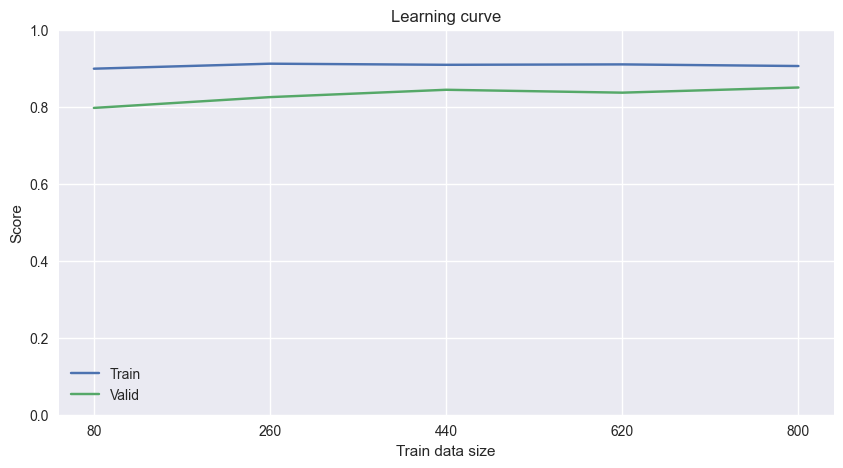

In [19]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в функцию plot_learning_curve(). У функции будет несколько аргументов: модель, набор данных (X, y), кросс-валидатор, метрика, координатная плоскость matplotlib, на которой будет строиться график, и подпись графика:

In [20]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Теперь, когда у нас есть наша функция, давайте построим кривые обучения для нескольких моделей. Будем использовать следующие модели:

логистическую регрессию,
дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
дерево решений без ограничений.
Создадим список, в котором будем хранить эти модели:

In [21]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию plot_learning_curve():

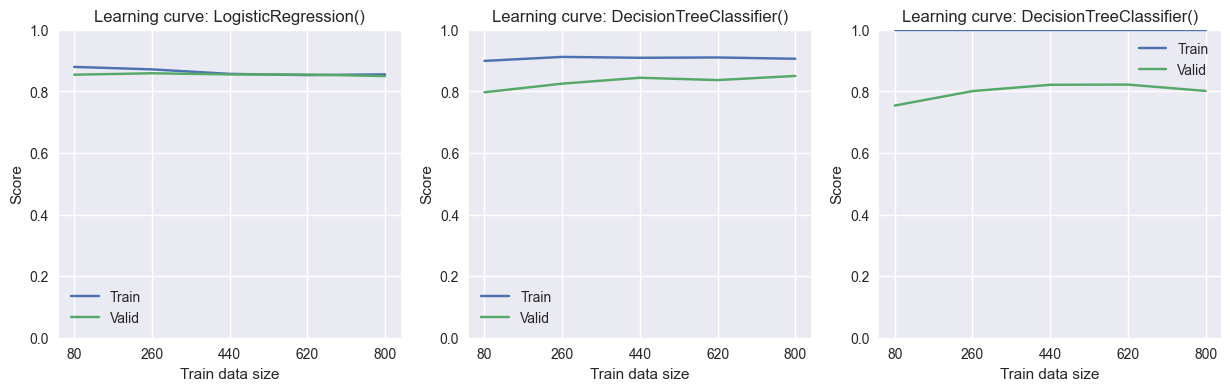

In [22]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

Благодаря построенным графикам мы можем легко сравнить три представленные модели между собой. 

Первый график, построенный для логистической регрессии, говорит нам о том, что для данной модели качество на тренировочных и валидационных фолдах практически одинаково (кривые проходят очень близко друг к другу), то есть переобучения нет. Однако данная модель обладает низким качеством: кривые не превышают даже значения 0.5. Модель является недообученнной.
Третий график, построенный для дерева решений без ограничений глубины, явно указывает на наличие переобучения: тренировочная кривая всё время находится в области своего максимума — 1, а вот валидационная кривая не может достичь такой высокой отметки.
Из всех представленных оптимальной является модель дерева решений с ограничениями, кривая обучения которой изображена на втором графике. Тренировочная и валидационная кривые постепенно сходятся к единой отметке качества, и полученная метрика превышает отметку в 0.5.